# Part 1: Scraping One Page

#### 1) Used libraries

In [2]:
import re # making regular expression
import pandas as pd # reading and processing data
from nltk.tokenize import word_tokenize  # tokenize text
from nltk.corpus import stopwords # removing stopwords
from collections import Counter # counting the frequency of words
import matplotlib.pyplot as plt # plotting
import requests # request html content
from bs4 import BeautifulSoup # handle html content, e.g. searching
from multiprocessing.pool import ThreadPool # used for processing articles using threads
import os # used for check how many cores the PC have
from tqdm import tqdm # showing progress
import numpy as np

#### 2) Retrieve document

In [10]:
# Get the content:
url = 'https://www.bbc.com/news'
repsonse = requests.get(url)
content = repsonse.text

I am searching for the following news title

![news_title_to_find](news_title_to_find.png)

In [11]:
news_title_to_find = 'Covid origin likely China lab incident - FBI chief'

In [12]:
# Try to find the news title of interest:
start_index = content.find(news_title_to_find)
if start_index>0:
    print(f"News title:\n   {content[start_index:start_index+len(news_title_to_find)]}\nIS FOUND!")
else:
    print("News title NOT found")

News title:
   Covid origin likely China lab incident - FBI chief
IS FOUND!


<ins>Comment</ins>:<br />
We are able to find the news title within the raw content just by using the standard string find() method.<br />
This method are returning the start index of the found title (if no found -1 is returned).<br />
This start index is then used to extract the whole title.

#### 3) Find news title within content ("manually" using Regular Expressions)

After inspecting the content of some news titles, we have found that the titles occurs in a h3-tag, therefore:

In [13]:
# Regular expression to extract news titles:
h3_regex = r'<h3 .*?">(.+?)<\/h3>'

# Extract news titles:
news_titles = re.findall(h3_regex, content)

# Remove duplicates:
news_titles = list(set(news_titles)) 

# Print all news titles:
print(f"Number of news titles: {len(news_titles)}\n\nNews titles:\n")
print(*news_titles, sep="\n")

Number of news titles: 39

News titles:

Get in touch
Survivors describe &#x27;nightmarish seconds&#x27; as trains crashed
BBC World News TV
Ruling party wins Nigeria&#x27;s presidential election
Record numbers of guide dog volunteers after BBC story
At the crash site of &#x27;no hope&#x27; - BBC reporter in Greece
Daily walk prevents one in 10 early deaths - study
TikTok answers three cyber-security fears about app
The people who want you to believe the Ukraine war is fake
Bieber cancels remaining Justice world tour dates
Station master arrested after dozens killed in Greece train crash
News daily newsletter
Pilot circles plane to show passengers northern lights
BBC World Service Radio
The return of the US&#x27; lost language
Why the Covid lab-leak theory is being taken seriously 
Ed Sheeran says wife developed tumour in pregnancy
World Cup record holder Fontaine dies
Denmark scraps holiday to boost defence budget
Indian temple replaces elephant with robot for rituals
Uranium particle

<ins>Comment</ins>:<br />
Some difficulities using regular expressions for this task is could be that the <br />
HTML structure can vary in its structure and especially when it comes to nested tags,<br />
special characters, and comments. To compensate for this complex regular expressions<br />
is needed for handling all scenarious. Also when changes are done in the HTML structure,<br />
then changes to the regular expressions are also needed. In addition to that dynamic content<br />
is also (nerely impossible) to handle with regular expressions e.g. content generated by JavaScript.<br />
But for this task of course this is not an issue.
 
Following issues is detected from the above printout:
 - Format issue: Apostrophes is not converted correctly.
 - Some additional header-titles are included, e.g. "Mobile app" and "Get in touch".<br />
   By inspecting the source code in Web Developer Tools, I found that each news titles is having the same class attached.<br />
   Therefore, we can filter the content based on that conclusion.

These two issues can be fixed, with the following changes to the code:

In [14]:
# Extract only news titles, not other titles:
h3_regex = r'<h3 class="gs-c-promo-heading__title .+?">(.+?)<\/h3>'

# Extract news titles:
news_titles = re.findall(h3_regex, content)

# Remove duplicates by converting to a set and back to list again:
news_titles = list(set(news_titles))

# Fix apostrophes:
news_titles = [item for item in map(lambda x: re.sub(r'(&#x27;)', "'", x), news_titles)]

# Print news titles:
print(f"Number of news titles: {len(news_titles)}\n\nNews titles:\n")
print(*news_titles, sep="\n")

Number of news titles: 36

News titles:

Survivors describe 'nightmarish seconds' as trains crashed
BBC World News TV
Ruling party wins Nigeria's presidential election
Record numbers of guide dog volunteers after BBC story
At the crash site of 'no hope' - BBC reporter in Greece
Daily walk prevents one in 10 early deaths - study
TikTok answers three cyber-security fears about app
The people who want you to believe the Ukraine war is fake
Bieber cancels remaining Justice world tour dates
Station master arrested after dozens killed in Greece train crash
Pilot circles plane to show passengers northern lights
BBC World Service Radio
The return of the US' lost language
Why the Covid lab-leak theory is being taken seriously 
Ed Sheeran says wife developed tumour in pregnancy
World Cup record holder Fontaine dies
Denmark scraps holiday to boost defence budget
Indian temple replaces elephant with robot for rituals
Uranium particles enriched to 83.7% found in Iran
Cold snap leaves Barcelona cove

<ins>Comment</ins>:<br />
After we have done filter out titles that are not at interest and done some replacements for apostrophes,<br />
we have the correct titles as in the webpage.

#### 4 & 5) Extract all news titles ("automatically" using BeautifulSoup)

We know from the previous task that the titles of interest is having the class 'gs-c-promo-heading__title'.

In [15]:
soup = BeautifulSoup(repsonse.content, 'html.parser')

# Extract news titles:
news_titles = [title.text for title in soup.find_all('h3', class_='gs-c-promo-heading__title')]

# Remove duplicates:
news_titles = list(set(news_titles))

# Print news titles:
print(f"Number of news titles: {len(news_titles)}\n\nNews titles:\n")
print(*news_titles, sep="\n")

Number of news titles: 36

News titles:

Survivors describe 'nightmarish seconds' as trains crashed
Ancient mummy found in delivery man's bag
BBC World News TV
Record numbers of guide dog volunteers after BBC story
Ruling party wins Nigeria's presidential election
Daily walk prevents one in 10 early deaths - study
TikTok answers three cyber-security fears about app
The people who want you to believe the Ukraine war is fake
Bieber cancels remaining Justice world tour dates
Station master arrested after dozens killed in Greece train crash
Ukraine war casts shadow over India's G20 ambitions
At the crash site of 'no hope' - BBC reporter in Greece
The return of the US' lost language
Pilot circles plane to show passengers northern lights
BBC World Service Radio
Why the Covid lab-leak theory is being taken seriously 
Ed Sheeran says wife developed tumour in pregnancy
World Cup record holder Fontaine dies
Denmark scraps holiday to boost defence budget
Indian temple replaces elephant with robot

<ins>Comment</ins>:<br />
Nice! We are getting the same number of news as the "manually" method.<br />
Notice that we are not having apostrophes issues with this library.

#### 6) Extract only top stories

In [16]:
# Get only top stories:
top_stories = [story.find('h3', class_='gs-c-promo-heading__title').text for story in 
               soup.find('div', class_='nw-c-top-stories--standard').find_all('div', class_='gs-c-promo-body')]

# Remove duplicates:
top_stories = list(set(top_stories))

# Print news titles:
print(f"Number of news titles: {len(top_stories)}\n\nNews titles:\n")
print(*top_stories, sep="\n")

Number of news titles: 14

News titles:

Survivors describe 'nightmarish seconds' as trains crashed
Bieber cancels remaining Justice world tour dates
Station master arrested after dozens killed in Greece train crash
Ed Sheeran says wife developed tumour in pregnancy
Finland starts construction of Russia border fence
World Cup record holder Fontaine dies
Denmark scraps holiday to boost defence budget
Uranium particles enriched to 83.7% found in Iran
At the crash site of 'no hope' - BBC reporter in Greece
Ancient mummy found in delivery man's bag
Twitter back after two-hour outage affected tweets
Ruling party wins Nigeria's presidential election
Daily walk prevents one in 10 early deaths - study
Covid origin likely China lab incident - FBI chief


<ins>Comment</ins>:<br />
We are now correctly only getting top stories.

#### 7) Extract summmaries of the news title and section it belongs to

In [17]:
# Find top stories:
top_stories = soup.find('div', class_='nw-c-top-stories').find_all('div', class_='gs-c-promo-body')

# Extract title, summary, and section for each top story:
top_stories = [{'title': item.find('h3', class_='gs-c-promo-heading__title').text,
                'summary': item.find('p', class_='gs-c-promo-summary').text,
                'section': item.find('a', class_='gs-c-section-link').text
               } for item in top_stories]

# Remove duplicates based on title
unique_top_stories = []
unique_titles = set() # set for checking if story is already found
for story in top_stories:
    if story['title'] not in unique_titles:
        unique_top_stories.append(story)
        unique_titles.add(story['title'])

print(f"Number of news titles: {len(unique_top_stories)}\n")
df = pd.DataFrame(unique_top_stories)
df

Number of news titles: 14



,title,summary,section
0,Station master arrested after dozens killed in...,The two trains which collided early on Wednesd...,Europe
1,Survivors describe 'nightmarish seconds' as tr...,Passengers smashed windows to escape burning c...,Europe
2,At the crash site of 'no hope' - BBC reporter ...,Kostas Koukoumakas takes a look at the devasta...,Europe
3,Covid origin likely China lab incident - FBI c...,Other US agencies have come to different concl...,US & Canada
4,Ruling party wins Nigeria's presidential election,"Bola Tinubu, 70, is declared the winner of Nig...",Africa
5,Ed Sheeran says wife developed tumour in pregn...,The health scare and the death of his friend J...,Entertainment & Arts
6,Uranium particles enriched to 83.7% found in Iran,A watchdog is discussing with Iran the purity ...,Middle East
7,Twitter back after two-hour outage affected tw...,The problems came two days after the social me...,Technology
8,Ancient mummy found in delivery man's bag,The Peruvian man said he wanted to show off th...,Latin America & Caribbean
9,Finland starts construction of Russia border f...,The Finnish government has sought to boost bor...,Europe


<ins>Comment</ins>:<br />
We are now correctly getting the summary for each top story and their corresponding section.

#### 8) Write news titles to csv file

In [18]:
# Save the dataframe to csv:
df.to_csv('bbc-news.csv', index=False)

# Part 2: Scraping a Reliable News Dataset

Extract all articles from "https://en.wikinews.org/wiki/Category:Politics_and_conflicts", with starting letters:

In [19]:
group_nr = 2
expression = "ABCDEFGHIJKLMNOPRSTUVWZABCDEFGHIJKLMNOPRSTUVWZ"[group_nr%23:group_nr%23+10]
expression = [*expression]
print("Letters to search for:")
print(*expression, sep=', ')

Letters to search for:
C, D, E, F, G, H, I, J, K, L


<ins>Comment</ins>:<br />
All articles with the letters printed out above should now be found:

In [20]:
base_url = 'https://en.wikinews.org'
nxt_url = base_url + '/wiki/Category:Politics_and_conflicts'

start_letter = expression[0]
# Get the letter after the last letter to search for
to_letter = chr(ord(expression[-1]) + 1)

# Get all links for the start letters to search for
items = []
i = 0
current_letter = ""
while current_letter <= expression[-1]:
    response = requests.get(nxt_url)
    content = response.content
    soup = BeautifulSoup(content, "html.parser")
    page = soup.find("div", {"id": "mw-pages"})
    nxt_url = base_url + page.find("a", string='next page').get('href')
    categories = page.findAll("div", {"class": "mw-category-group"})
    for category in categories:
        current_letter = category.find("h3").text
        if current_letter > expression[-1]:
            break
        if current_letter >= start_letter:
            urls = category.findAll("a")
            for url in urls:
                i=i+1
                print(f"Working on letter: {current_letter}; Item: {i}", end="\r")
                url = base_url + url.get('href')
                items.append([current_letter, url])

print("\n\nFinished!")

Working on letter: L; Item: 2682

Finished!


In [21]:
# Function to remove remove commas, multiple tabs, multiple newlines, multiple spaces and special characters::
def clean_text(text):
    # List of patterns and their appropriate replacements:
    patterns = {
        r'\t+': ' \t ',
        r'\n+': ' \n ',
        r'\s{2,}': ' ',
        r'\(|\)|\`|\'|\´|\"|\,|\!|\[|\]|\.|\?|\–|\&|\—|\”|\“|\%|\:|\;|\-': '',
    }
    
    # Lowercase all characters:
    text = text.lower()
    
    # Loop through each pattern and apply the pattern to each column and do replacement if needed:
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, str(text))

    return text

In [22]:
# Function to process the article link.
# Returning the start-letter, title, url, date and content
def process_item(item):
    current_letter, url = item
    
    # Get content:
    response = requests.get(url)
    content = response.content
    soup = BeautifulSoup(content, "html.parser")
    
    # Get title:
    title = soup.find("span", {"class": "mw-page-title-main"})
    title = title.get_text() if title else ''
    
    # Get article:
    article = soup.find("div", {"class": "mw-parser-output"})
    
    # Get date:
    if article:
        date = article.find('span', {"id": "publishDate"})
        if date:
            date = date.get('title')
        else:
            date = ''
    
    # Get text, combine it and clean it:
    text = article.findAll("p", recursive=False)
    text = ''.join(p.get_text() for p in text)
    text = clean_text(text)
    
    # Add articles to list:
    return [current_letter, title, url, date, text]

In [23]:
articles = []
# Create a thread pool by the size of CPU-cores x 2 (rule of thumb) for processing articles:
with ThreadPool(os.cpu_count()*2) as pool:
    # Use tqdm to show progress:
    # with imap ordering is kept and results can be received immediately
    for article in tqdm(pool.imap(process_item, items), total=len(items)):
        articles.append(article)

100%|██████████████████████████████████████████████████████████████████████████████| 2682/2682 [01:45<00:00, 25.39it/s]


In [24]:
# Save the list to pandas dataframe:
df = pd.DataFrame(articles, columns=['letter', 'title', 'url', 'date', 'content'])

# Convert date column to panda date:
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

# Remove the date at the beginning of the content using regex:
pattern = r'^(.+? .+? \d{1,2} \d{4}.?)'
df['content'] = df[['content']].applymap(lambda x: re.sub(pattern, '', x))

# Print the dataframe:
df

,letter,title,url,date,content
0,C,Cabinet Minister resigns after boycott in Grenada,https://en.wikinews.org/wiki/Cabinet_Minister_...,2010-11-23,a grenadian cabinet minister has resigned afte...
1,C,Cabinet shuffled in Ontario,https://en.wikinews.org/wiki/Cabinet_shuffled_...,2006-09-19,ontario premier dalton mcguinty implemented a ...
2,C,Cabinet to discuss UK nuclear deterrent for th...,https://en.wikinews.org/wiki/Cabinet_to_discus...,2006-11-22,the labour partys 2005 election manifesto read...
3,C,CAFTA faces tough vote in U.S. House,https://en.wikinews.org/wiki/CAFTA_faces_tough...,2005-07-27,president bush is lobbying the us house of rep...
4,C,Cairo blast kills 3,https://en.wikinews.org/wiki/Cairo_blast_kills_3,NaN,april 8 2005 visitors to popular tourist spots...
...,...,...,...,...,...
2677,L,Lula's future in the hands of Brazilian Parlia...,https://en.wikinews.org/wiki/Lula%27s_future_i...,2005-06-12,the government of brazilian president luiz iná...
2678,L,"Lula: Venezuela ""does not lack democracy""",https://en.wikinews.org/wiki/Lula:_Venezuela_%...,2007-11-18,in statements to the press on november 14 the ...
2679,L,Luxembourg head of government resigns after ei...,https://en.wikinews.org/wiki/Luxembourg_head_o...,2013-07-13,prime minister jeanclaude juncker of the grand...
2680,L,Luxembourg votes Yes to the EU treaty,https://en.wikinews.org/wiki/Luxembourg_votes_...,2005-07-10,the people of luxembourg voted a slight yes to...


In [25]:
# Save the dataframe to csv:
df.to_csv('wiki.csv', index=False)

<ins>Comment</ins>:<br/>
With the above code we are able to get the title, url, date and the content of the articles using threads.<br/>
Notice that I am only retrieving the content which occurs inside p-tags, one could of course argue, <br/>
other tags should be included as well.<br/>
ThreadPool is suitable for I/O-bound tasks that involve waiting for I/O operations,<br/>
such as network requests or file I/O, which indeed is the case here.<br />
By using threads we can improve the performance by allowing other tasks to be executed while waiting.<br/>
Threads are chosen instead of Pool (multiprocessing/cores), since the bottle-neck here is <br/>
the amount network requests not the amount of CPU-power.

##### Statistics:
 - Year with most articles
 - Most frequent words
 - Average number of words in the articles

##### Year with most articles:

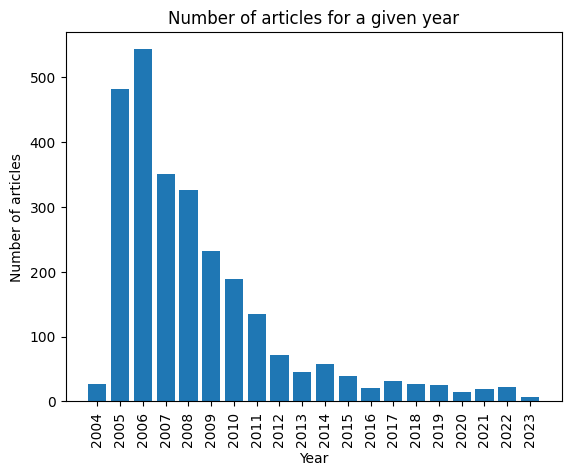

In [26]:
# Extract the year from each date:
year_counts = pd.to_datetime(df['date']).dropna().dt.year.value_counts() # dropna(): dropping empty values

# Plot the year frequency distribution
plt.bar(year_counts.index, year_counts.values)
plt.xticks(year_counts.index, rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Number of articles for a given year')
plt.show()

<ins>Comment</ins>:<br/>
From the above we can see that a lot of articles was made in the years 2005-2008(10).<br />
This could be that between 2005 and 2008, there were several notable political events and conflicts,<br />
such as the Iraq War, the election of Barack Obama as the President, and the global financial crisis.<br />
As a result, it is likely that many news articles were written about these events during<br />
that time period and subsequently added to Wikinews.

##### Most frequent words:

In [27]:
def remove_stopwords(words):
    # Remove stopwords
    stop_words = stopwords.words("english")
    
    # Loop through all elements and remove stopwords
    return [word for word in words if word not in stop_words]  # Remove stopwords from the list

In [28]:
def count_word_frequency(words):
    # Create a Counter list
    frequency = Counter()
    
    # Update/add list of words
    frequency.update(words)
    
    # Return the sorted dictionary based on the frequency of each word
    return sorted(frequency.items(), key=lambda x: x[1], reverse=True)

In [29]:
def plot_word_frequency(sorted_frequency):
    # Number of words to list of frequency
    nwords = 50

    # Extract the words and their frequency from the sorted list
    words = [x[0] for x in sorted_frequency[:nwords]]
    frequency = [x[1] for x in sorted_frequency[:nwords]]

    # Plot a barplot using matplotlib
    plt.bar(words, frequency)
    plt.ylabel('Frequency')
    plt.title('Frequency of the 50 most frequent words')
    plt.xticks(rotation=90)
    plt.show()

In [30]:
# Get the content a join them together:
contents = df["content"].tolist()
contents = "".join(contents)

# Create a list of words
tokens = word_tokenize(contents)

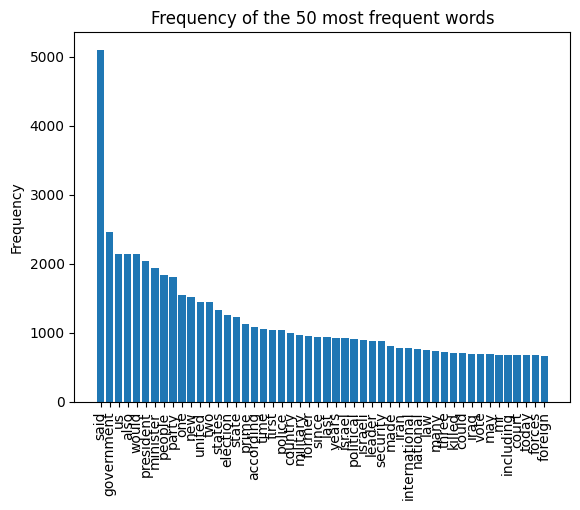

In [31]:
# Remove stopwords
words = remove_stopwords(tokens)
# Count the frequency of each word:
word_frequency = count_word_frequency(words)
# Plot the frequency of words
plot_word_frequency(word_frequency)

<ins>Comment</ins>:<br/>
From the above we can see the most frequent words are in a political tone. 

##### Average number of words in the articles:

Average number of words: 319
Number of outliers: 146, from a total of 2682 articles


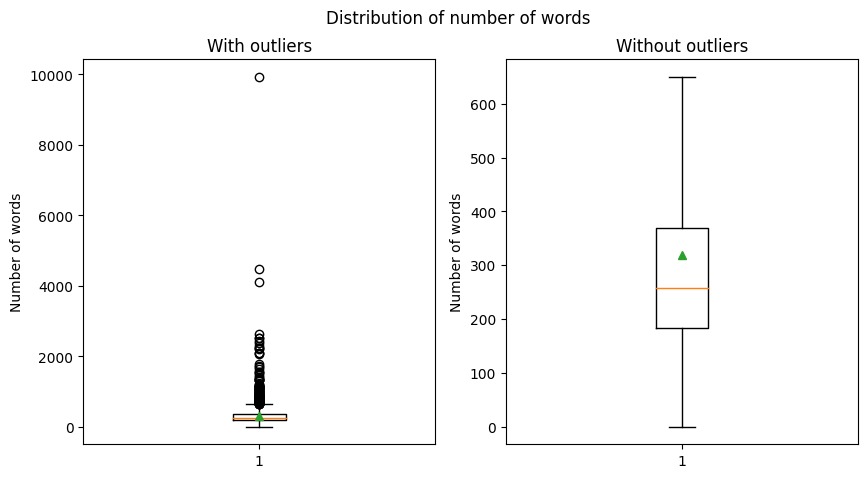

In [32]:
# Split the column into a list of words and then calculate the number of words:
word_count = df['content'].str.split().apply(len)

# Calculate the average number of words:
average_word_count = word_count.mean()

print(f"Average number of words: {int(average_word_count)}")

# Generate a box plot of the word counts:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

box_plot_data = ax1.boxplot(word_count, showfliers=True, showmeans=True)
ax1.set_title('With outliers')
ax1.set_ylabel('Number of words')

# Count outliers
outliers = [point for point in box_plot_data['fliers'][0].get_ydata()]
outlier_count = len(outliers)
print(f"Number of outliers: {outlier_count}, from a total of {len(articles)} articles")

ax2.boxplot(word_count, showfliers=False, showmeans=True)
ax2.set_title('Without outliers')
ax2.set_ylabel('Number of words')

# Show the plot:
fig.suptitle('Distribution of number of words')
plt.show()

<ins>Comment</ins>:<br />
From the above we can see that the main part of the articles contains between ~200 to ~400 words<br />
if we remove the 146 outliers from a total of 2683 articles.